In [1]:
import os
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm
import argparse
import logging
from datetime import datetime, timedelta, date
import torch
import torch.nn.functional as F
from sklearn.metrics import *
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from torch_geometric.utils.convert import from_networkx
import random

In [2]:
SEED = 0
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
random.seed(SEED)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
# Data Loading
data_root_path = '/media/usr/HDD/Data/NAVER'
partition_list = os.listdir(data_root_path)
partition_list = [p for p in partition_list if p[0]=='2']
partition_list = np.sort(partition_list)

data_path = '/media/usr/HDD/Working/Naver_Data/data_parsing'

sids_all = []
eventID_all = []

for partition in partition_list:
    try: 
        eventID_list = [filename.split('.')[0] for filename in os.listdir(os.path.join(data_path, 'networks', partition)) if filename[0] != '.']
        eventID_list = np.unique(eventID_list)
        eventID_all.append(eventID_list)

        for eventID in eventID_list:
            with open(os.path.join(data_path, 'networks', partition, '{}.pickle'.format(eventID)), 'rb') as f:
                accident_info = pickle.load(f)
            G = nx.read_gpickle(os.path.join(data_path, 'networks', partition, '{}.gpickle'.format(eventID)))

            sids_all.append(accident_info[1])
            sids_all.append(accident_info[2])
    except:
        continue

eventID_all = [x for y in eventID_all for x in y]
eventID_all = np.unique(eventID_all)
        
sids_all = [x for y in sids_all for x in y]
sids_all = np.unique(sids_all)

print('# of all Events, # of sids = ', len(eventID_all), len(sids_all))

data_extraction_path = '/media/usr/HDD/Data/NAVER_df'
filtered_ID = [eventID for eventID in eventID_all if eventID in os.listdir(data_extraction_path)]

## load accident_all
accident_all = pd.read_csv('datasets/data/accident_all.csv', index_col=0)
print("# of filtered Events = ", len(accident_all))


# Profile Extraction Functions
def profile_extraction2(speed_all):
    # Day of Week => monday : 0, sunday : 6
    speed_all['weekday'] = [s.weekday() for s in speed_all.index]
    speed_all['timestamp'] = [s.time() for s in speed_all.index]
    
    profile_mean = speed_all.groupby(['weekday', 'timestamp']).mean()
    profile_std = speed_all.groupby(['weekday', 'timestamp']).std()
    
    speed_all = speed_all.drop(['weekday', 'timestamp'], axis=1)
    
    return speed_all, profile_mean, profile_std

# of all Events, # of sids =  4203 15629
# of filtered Events =  849


In [4]:
accident_all.accident_sid.value_counts()[:10]

1210005301    20
1030001902    19
1220005401    15
1210003000    13
1130052300    12
1130006501    10
1190000200     9
1020000902     9
1220005502     8
1210005402     8
Name: accident_sid, dtype: int64

In [5]:
    target_sid = 1030001902  ## 1210005301    ## 1030001902
    accident_case = accident_all[accident_all.loc[:, 'accident_sid'] == target_sid]
    eventID = accident_case.eventId.iloc[0]
    normalize = 'profile'

In [6]:
def preprocessing(eventID, normalize):
    eventID = str(eventID)

    # accident info : 0 : description / 1 : sid / 2 : sid 
    # what sids?
    with open(os.path.join(data_path, 'speeds', eventID, '{}.pickle'.format(eventID)), 'rb') as f:
        accident_info = pickle.load(f)
    G = nx.read_gpickle(os.path.join(data_path, 'speeds', eventID, '{}.gpickle'.format(eventID)))

    sid_list = accident_info[1] + accident_info[2]

    accident_sid = accident_info[0]['sids'][0]
    accident_created = accident_info[0]['created']

    # feature extraction
    with open(os.path.join(data_extraction_path, eventID), 'rb') as f:
        test = pickle.load(f)
    speed_inflow = test['speed_inflow']
    speed_outflow = test['speed_outflow']

    speed_all = pd.concat([speed_inflow, speed_outflow], axis=1)
    speed_all = speed_all.dropna(axis=1, how='all')
    
    tmp = speed_all[accident_sid].iloc[:, 0].values
    speed_all = speed_all.drop([accident_sid], axis=1)
    speed_all[accident_sid] = tmp

    ## selected nodes
    sid_list = list(set(list(speed_inflow.columns) + list(speed_outflow.columns) + [accident_sid]))
    H = nx.subgraph(G, sid_list)

    ## speed_all 5min rolling & normalize
    speed_all = speed_all.resample(rule='5T').mean()
    if normalize == 'standard':
        scaler = StandardScaler() 
        arr_scaled = scaler.fit_transform(speed_all) 
        df_all_norm = pd.DataFrame(arr_scaled, columns=speed_all.columns,index=speed_all.index)
    elif normalize == 'minmax':
        scaler = MinMaxScaler() 
        arr_scaled = scaler.fit_transform(speed_all) 
        df_all_norm = pd.DataFrame(arr_scaled, columns=speed_all.columns,index=speed_all.index)
    elif normalize == 'profile':
        ## profile extraction
        # profile_all = profile_extraction(df_all_norm)
        speed_all, profile_mean, profile_std = profile_extraction2(speed_all)

        ## profile normalization
        date_index = np.arange(datetime(2020, 9, 2), datetime(2021, 3, 1), timedelta(days=1)).astype(datetime)
        df_all_norm = speed_all.copy()

        for date in date_index:
            date_index = np.arange(date, date+timedelta(days=1), timedelta(minutes=5)).astype(datetime)
            tmp = speed_all.loc[date_index]
            weekday = date.weekday()
            mean_tmp = profile_mean[288*weekday:288*(weekday+1)]
            std_tmp = profile_std[288*weekday:288*(weekday+1)]

            normalized = (tmp.values - mean_tmp) / std_tmp
            df_all_norm.loc[date_index] = normalized.values

    # define anomaly label
    labels = []
    accident_case = accident_all[accident_all.loc[:, 'accident_sid'] == accident_sid]
    accident_case['created'] = pd.to_datetime(accident_case['created'])
    for ix, row in accident_case.iterrows():
        accident_created = row['created']
        min = accident_created.minute % 5
        sec = accident_created.second
        accident_pt = accident_created - timedelta(minutes=min, seconds=sec)
        labels.append(list(map(int, (df_all_norm.index >= accident_pt+timedelta(minutes=-60)) & (df_all_norm.index < accident_pt+timedelta(minutes=60)))))
    labels = list(map(int, (np.sum(labels, axis=0) > 0)))
    label_df = pd.DataFrame(labels, index=df_all_norm.index, columns=['label'])
    
    return df_all_norm, label_df, H

In [7]:
df_all_norm, label_df, H = preprocessing(eventID, normalize)

train_df = df_all_norm[df_all_norm.index < datetime(2020, 12, 1)]
val_df = df_all_norm[(df_all_norm.index >= datetime(2020, 12, 1)) & (df_all_norm.index < datetime(2021, 1, 1))]
test_df = df_all_norm[(df_all_norm.index >= datetime(2021, 1, 1)) & (df_all_norm.index < datetime(2021, 2, 1))]

train_label = label_df[label_df.index < datetime(2020, 12, 1)]
val_label = label_df[(label_df.index >= datetime(2020, 12, 1)) & (label_df.index < datetime(2021, 1, 1))]
test_label = label_df[(label_df.index >= datetime(2021, 1, 1)) & (label_df.index < datetime(2021, 2, 1))]

# train_df = train_df.fillna(0)
# val_df = val_df.fillna(0)
# test_df = test_df.fillna(0)
train_df = train_df.bfill(limit=36).ffill(limit=36).fillna(0, limit=288).dropna(axis=1)
val_df = val_df.bfill(limit=36).ffill(limit=36).fillna(0, limit=288).dropna(axis=1)
test_df = test_df.bfill(limit=36).ffill(limit=36).fillna(0, limit=288).dropna(axis=1)


/tmp/ipykernel_388557/1432263826.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  accident_case['created'] = pd.to_datetime(accident_case['created'])


In [8]:
train_df.shape

(25920, 21)

# Evaluation

In [9]:
## https://github.com/mangushev/mtad-tf/blob/main/evaluate.py
#just like onmianomaly, no delta. If we hit anuthing in anomaly interval, whole anomaly segment is correctly identified
#-----------------------
#1|0|1|1|1|0|0|0|1|1|1|1  Labels
#-----------------------
#0|0|0|1|1|0|0|0|0|0|1|0  Predictions
#-----------------------
#0|0|1|1|1|0|0|0|1|1|1|1  Adjusted
#-----------------------
def adjust_predictions(predictions, labels):
  adjustment_started = False
  new_pred = predictions

  for i in range(len(predictions)):
    if labels[i] == 1:
      if predictions[i] == 1:
        if not adjustment_started:
          adjustment_started = True
          for j in range(i, 0, -1):
            if labels[j] == 1:
              new_pred[j] = 1
            else:
              break
    else:
      adjustment_started = False

    if adjustment_started:
      new_pred[i] = 1
      
  return new_pred

In [10]:
def evaluate(label_all, score_all, adjust = False, plot=False, print_=False):
    true = label_all
    pred = list(map(int, [s>0 for s in score_all]))
    if adjust:
        pred = adjust_predictions(pred, true)
    CM = confusion_matrix(true, pred)
    TN = CM[0][0]
    FN = CM[1][0]
    TP = CM[1][1]
    FP = CM[0][1]
    acc = accuracy_score(true, pred)
    auc = roc_auc_score(true, pred)
#     far = FP / (FP+TN)
    far = FP / (FP+TP)
    pre = precision_score(true, pred, pos_label=1)
    rec = recall_score(true, pred, pos_label=1)
    macro_f1 = f1_score(true, pred, average='macro')
    ap = average_precision_score(true, pred)
    if plot:
        plt.figure(figsize=(40, 5))
        plt.plot(true)
        plt.plot(pred)
    if print_:
        print('Accuracy \t{:.4f}'.format(accuracy_score(true, pred)))
        print('AUC score \t{:.4f}'.format(roc_auc_score(true, pred)))
        print('FAR score \t{:.4f}'.format(far))
        print('Precision \t{:.4f}'.format(precision_score(true, pred, pos_label=1)))
        print('Recall   \t{:.4f}'.format(recall_score(true, pred, pos_label=1)))
        print('Macro F1 \t{:.4f}'.format(f1_score(true, pred, average='macro')))
        print('Avg Precision \t{:.4f}'.format(ap))
        print(classification_report(true, pred))
    return [acc, auc, far, pre, rec, macro_f1, ap]

# Random

## Random Case

In [11]:
print(test_label.sum())
label_all = test_label.values

label    144
dtype: int64


In [12]:
random_result = []
for i in tqdm(range(20)):
    for nu in [0.01, 0.05, 0.1, 0.2]:
        true = label_all
        pred = np.random.choice(np.arange(2), len(true), p=[1-nu, nu])
        acc, auc, far, pre, rec, macro_f1, ap = evaluate(label_all, pred, adjust=False, plot=False)
        random_result.append(['random', None, nu, False, acc, auc, far, pre, rec, macro_f1, ap])
        acc, auc, far, pre, rec, macro_f1, ap = evaluate(label_all, pred, adjust=True, plot=False)
        random_result.append(['random', None, nu, True, acc, auc, far, pre, rec, macro_f1, ap])

100%|██████████| 20/20 [00:06<00:00,  3.12it/s]


In [13]:
random_result = pd.DataFrame(random_result, columns=['model', 'normalize', 'nu', 'adjust', 'acc', 'auc', 'far', 'precision', 'recall', 'f1_score', 'AP'])
random_result.groupby(['nu', 'adjust']).mean()

/tmp/ipykernel_388557/549230291.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  random_result.groupby(['nu', 'adjust']).mean()


acc       auc       far  precision    recall  f1_score  \
nu   adjust                                                                
0.01 False   0.973998  0.500276  0.983141   0.016859  0.010764  0.499969   
     True    0.977453  0.607394  0.764004   0.235996  0.225000  0.608678   
0.05 False   0.936162  0.495734  0.986558   0.013442  0.040625  0.493599   
     True    0.945721  0.792088  0.827227   0.172773  0.633333  0.621603   
0.10 False   0.886503  0.501235  0.983477   0.016523  0.103125  0.484103   
     True    0.899894  0.916339  0.868087   0.131913  0.933333  0.588794   
0.20 False   0.792064  0.498153  0.984170   0.015830  0.194444  0.456416   
     True    0.804923  0.896764  0.924165   0.075835  0.991667  0.515428   

                   AP  
nu   adjust            
0.01 False   0.016258  
     True    0.090975  
0.05 False   0.016104  
     True    0.124027  
0.10 False   0.016234  
     True    0.124979  
0.20 False   0.016130  
     True    0.075423

In [14]:
random_result.groupby(['nu', 'adjust']).mean().to_csv('result/random_acc1902.csv')

/tmp/ipykernel_388557/1693594522.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  random_result.groupby(['nu', 'adjust']).mean().to_csv('result/random_acc1902.csv')


# Univariate

### Rule-based (Profile Detection Case)

In [15]:
df_all_norm, label_df, _ = preprocessing(eventID, 'profile')

/tmp/ipykernel_388557/1432263826.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  accident_case['created'] = pd.to_datetime(accident_case['created'])


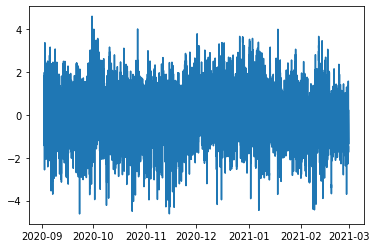

In [16]:
plt.plot(df_all_norm[target_sid])

In [17]:
test_df = df_all_norm[(df_all_norm.index >= datetime(2021, 1, 1)) & (df_all_norm.index < datetime(2021, 2, 1))]
test_label = label_df[(label_df.index >= datetime(2021, 1, 1)) & (label_df.index < datetime(2021, 2, 1))]
# test_label.reset_index(inplace=True)
# test_label.loc[:, 'weekday'] = test_label.loc[:, 'datetime'].apply(lambda s: s.weekday())
# test_label.loc[:, 'timestamp'] = test_label.loc[:, 'datetime'].apply(lambda s: s.time())
test_label.value_counts()

label
0        8784
1         144
dtype: int64

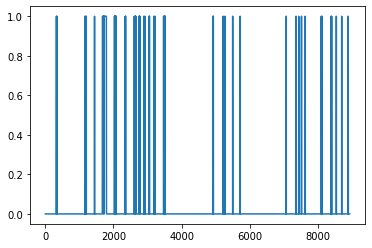

In [18]:
pred = list(map(int, (test_df[target_sid] < -2).values))
plt.plot(pred)

In [19]:
true = test_label.values
len(test_label), len(pred)

(8928, 8928)

Accuracy 	0.9600
AUC score 	0.5254
FAR score 	0.9532
Precision 	0.0468
Recall   	0.0764
Macro F1 	0.5188
Avg Precision 	0.0185
              precision    recall  f1-score   support

           0       0.98      0.97      0.98      8784
           1       0.05      0.08      0.06       144

    accuracy                           0.96      8928
   macro avg       0.52      0.53      0.52      8928
weighted avg       0.97      0.96      0.96      8928



[0.960013440860215,
 0.5254439890710383,
 0.9531914893617022,
 0.04680851063829787,
 0.0763888888888889,
 0.5188103233454356,
 0.01847260352322123]

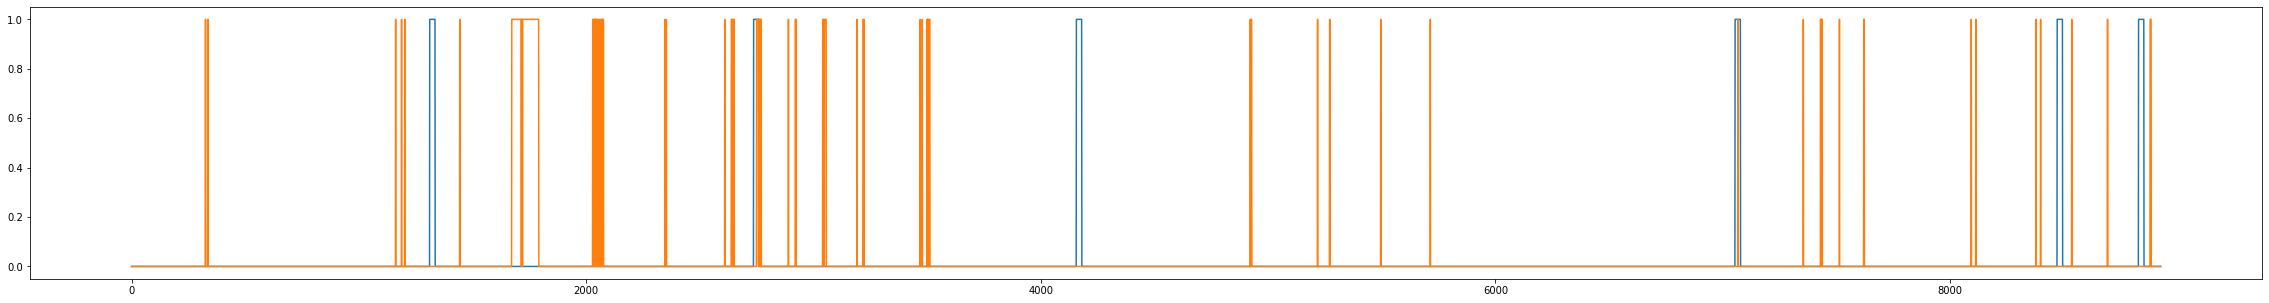

In [20]:
evaluate(true, pred, adjust=False, plot=True, print_=True)

Accuracy 	0.9642
AUC score 	0.6539
FAR score 	0.8235
Precision 	0.1765
Recall   	0.3333
Macro F1 	0.6062
Avg Precision 	0.0696
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      8784
           1       0.18      0.33      0.23       144

    accuracy                           0.96      8928
   macro avg       0.58      0.65      0.61      8928
weighted avg       0.98      0.96      0.97      8928



[0.96415770609319,
 0.6539162112932605,
 0.8235294117647058,
 0.17647058823529413,
 0.3333333333333333,
 0.6062103034580099,
 0.06957621758380772]

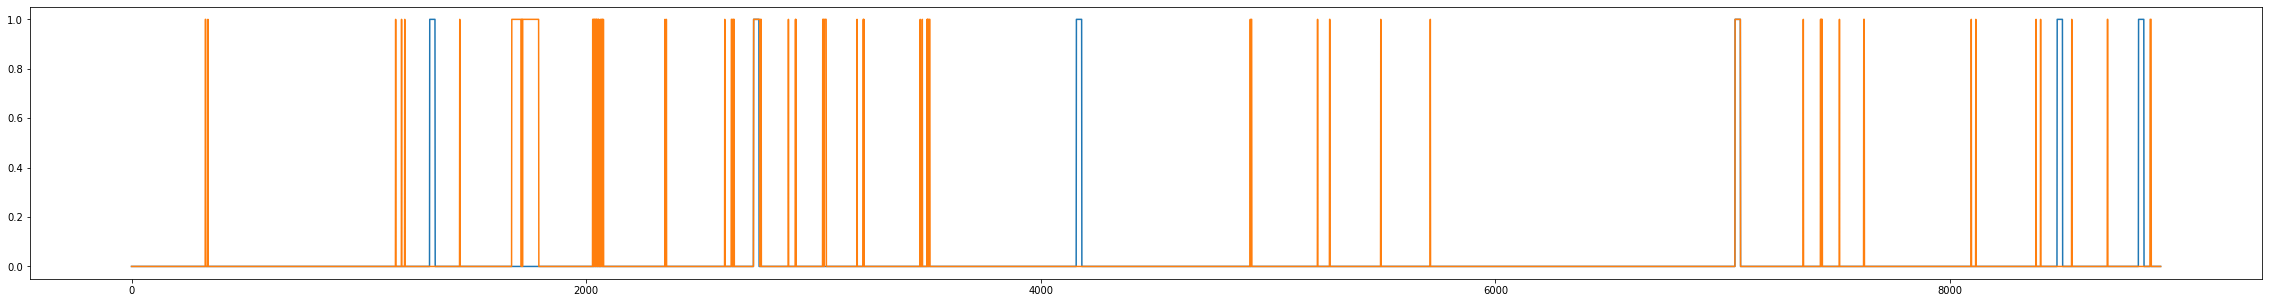

In [21]:
evaluate(true, pred, adjust=True, plot=True, print_=True)

### ARIMA

In [23]:
from statsmodels.tsa.arima.model import ARIMA

In [24]:
import warnings
warnings.filterwarnings("ignore")

In [25]:
df_all_norm, label_df, _ = preprocessing(eventID, 'standard')

train_df = df_all_norm[df_all_norm.index < datetime(2020, 12, 1)]
val_df = df_all_norm[(df_all_norm.index >= datetime(2020, 12, 1)) & (df_all_norm.index < datetime(2021, 1, 1))]
test_df = df_all_norm[(df_all_norm.index >= datetime(2021, 1, 1)) & (df_all_norm.index < datetime(2021, 2, 1))]

train_label = label_df[label_df.index < datetime(2020, 12, 1)]
val_label = label_df[(label_df.index >= datetime(2020, 12, 1)) & (label_df.index < datetime(2021, 1, 1))]
test_label = label_df[(label_df.index >= datetime(2021, 1, 1)) & (label_df.index < datetime(2021, 2, 1))]

# train_df = train_df.fillna(0)
# val_df = val_df.fillna(0)
# test_df = test_df.fillna(0)
train_df = train_df.bfill(limit=36).ffill(limit=36).fillna(0, limit=288).dropna(axis=1)
val_df = val_df.bfill(limit=36).ffill(limit=36).fillna(0, limit=288).dropna(axis=1)
test_df = test_df.bfill(limit=36).ffill(limit=36).fillna(0, limit=288).dropna(axis=1)

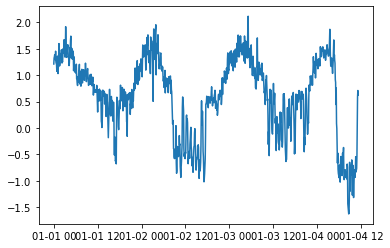

In [26]:
plt.plot(test_df.iloc[:1000][target_sid])

In [35]:
dev_all = []
for i in tqdm(range(val_df.shape[0]-24)):
    model = ARIMA(val_df.iloc[i:i+24][target_sid], order=(1,1,1), enforce_stationarity=False, enforce_invertibility=False)
    results = model.fit()
    pred = results.forecast(1)
    true = val_df.iloc[i+24][target_sid]
    # df_pred.append(pred)
    dev_all.append(np.abs(true - pred).item())
# df_pred = pd.DataFrame(df_pred)
# df_pred.columns=df_test.columns
threshold = np.quantile(dev_all, q=0.95)

100%|██████████| 8904/8904 [04:41<00:00, 31.67it/s]


In [36]:
threshold

0.4661860095610303

In [37]:
dev_all = []
for i in tqdm(range(test_df.shape[0]-24)):
    model = ARIMA(test_df.iloc[i:i+24][target_sid], order=(1,1,1), enforce_stationarity=False, enforce_invertibility=False)
    results = model.fit()
    pred = results.forecast(1)
    true = test_df.iloc[i+24][target_sid]
    dev_all.append(np.abs(true - pred).item())

100%|██████████| 8904/8904 [04:34<00:00, 32.46it/s]


In [38]:
score_all = dev_all - threshold
true_label = test_label.label

In [39]:
score_all

array([-0.46370769, -0.30657138, -0.41211399, ..., -0.22233729,
       -0.32492123, -0.27208682])

Accuracy 	0.9620
AUC score 	0.9807
FAR score 	0.7012
Precision 	0.2988
Recall   	1.0000
Macro F1 	0.7202
Avg Precision 	0.2988
              precision    recall  f1-score   support

           0       1.00      0.96      0.98      8760
           1       0.30      1.00      0.46       144

    accuracy                           0.96      8904
   macro avg       0.65      0.98      0.72      8904
weighted avg       0.99      0.96      0.97      8904



[0.9620395327942498,
 0.9807077625570777,
 0.7012448132780082,
 0.2987551867219917,
 1.0,
 0.720196074129141,
 0.2987551867219917]

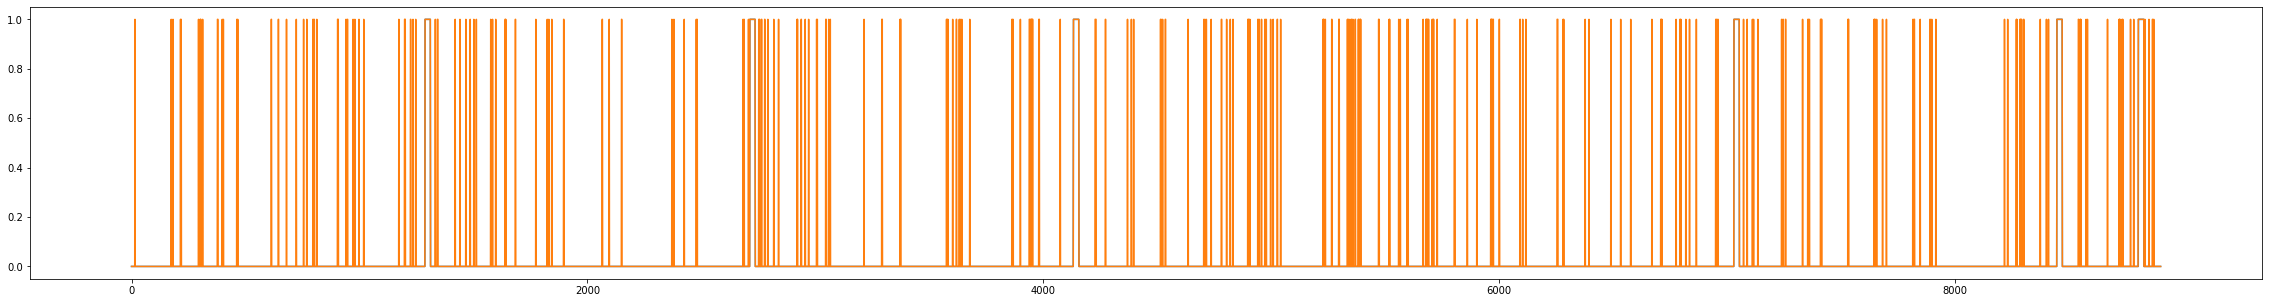

In [40]:
evaluate(true_label[24:].values, score_all, adjust=True, plot=True, print_=True)

## OCSVM

In [27]:
from sklearn.svm import OneClassSVM

In [28]:
train_df.head()

sid,1030001800,1030002400,1030002701,1030016506,1030040600,1030041300,1030045400,1030065700,1050000301,1050060000,...,1030000500,1030000700,1030001100,1030001300,1030008004,1030026600,1030028600,1030029200,1030029600,1030001902
datetime,,,,,,,,,,,,,,,,,,,,,
2020-09-02 00:00:00,1.001661,1.118983,0.902882,1.195910,0.647205,0.789702,-0.060996,0.378988,0.973621,1.032954,...,0.995827,0.989388,1.197671,1.023102,1.193770,0.644452,0.217658,1.193176,1.343063,1.242347
2020-09-02 00:05:00,1.200408,0.873292,0.936426,3.160571,0.508066,0.949731,1.009879,0.598190,1.085784,0.820927,...,0.980284,1.070756,0.699452,1.054397,1.089729,0.646500,0.776910,0.433857,1.150648,0.942780
2020-09-02 00:10:00,0.888834,0.734483,0.883688,2.346112,0.352332,0.646989,1.051613,0.431366,0.891992,1.099333,...,0.974506,0.919249,1.236480,0.790833,1.193053,0.767188,1.746515,1.160648,1.272481,1.282379
2020-09-02 00:15:00,0.944755,1.128218,0.895700,1.671118,0.429299,0.704367,0.960051,0.609482,0.868688,1.359681,...,1.095388,0.974145,0.467965,1.009600,1.117326,0.825836,0.693706,1.720267,1.434209,1.193949
2020-09-02 00:20:00,0.979219,0.997222,0.787184,0.100352,0.763532,0.536167,0.770325,0.678828,0.681530,1.320628,...,1.333876,1.192020,0.873900,0.875490,1.135003,0.777828,0.647556,0.454327,1.156882,1.177586


In [29]:
train_data, test_data = [], []
for i in tqdm(range(train_df.shape[0]-24)):
    if 1 in train_label.iloc[i:i+24]['label'].values:
        continue
    else:
        train_data.append(train_df.iloc[i:i+24][target_sid])
for i in tqdm(range(test_df.shape[0]-24)):
    test_data.append(test_df.iloc[i:i+24][target_sid])
train_data = np.stack(train_data)
test_data = np.stack(test_data)

100%|██████████| 8904/8904 [00:01<00:00, 8616.81it/s] 


In [30]:
train_data.shape, test_data.shape

((25755, 24), (8904, 24))

In [31]:
clf = OneClassSVM(gamma='auto').fit(train_data[:])

In [32]:
true = test_label.iloc[24:].label.values
pred = clf.predict(test_data)
pred = [1 if p==1 else 0 for p in pred]

In [33]:
np.unique(true), np.unique(pred)

(array([0, 1]), array([0, 1]))

Accuracy 	0.3913
AUC score 	0.6906
FAR score 	0.9741
Precision 	0.0259
Recall   	1.0000
Macro F1 	0.3013
Avg Precision 	0.0259
              precision    recall  f1-score   support

           0       1.00      0.38      0.55      8760
           1       0.03      1.00      0.05       144

    accuracy                           0.39      8904
   macro avg       0.51      0.69      0.30      8904
weighted avg       0.98      0.39      0.54      8904



[0.3912848158131177,
 0.6906392694063928,
 0.97411933860532,
 0.025880661394680086,
 1.0,
 0.3012608083768178,
 0.025880661394680086]

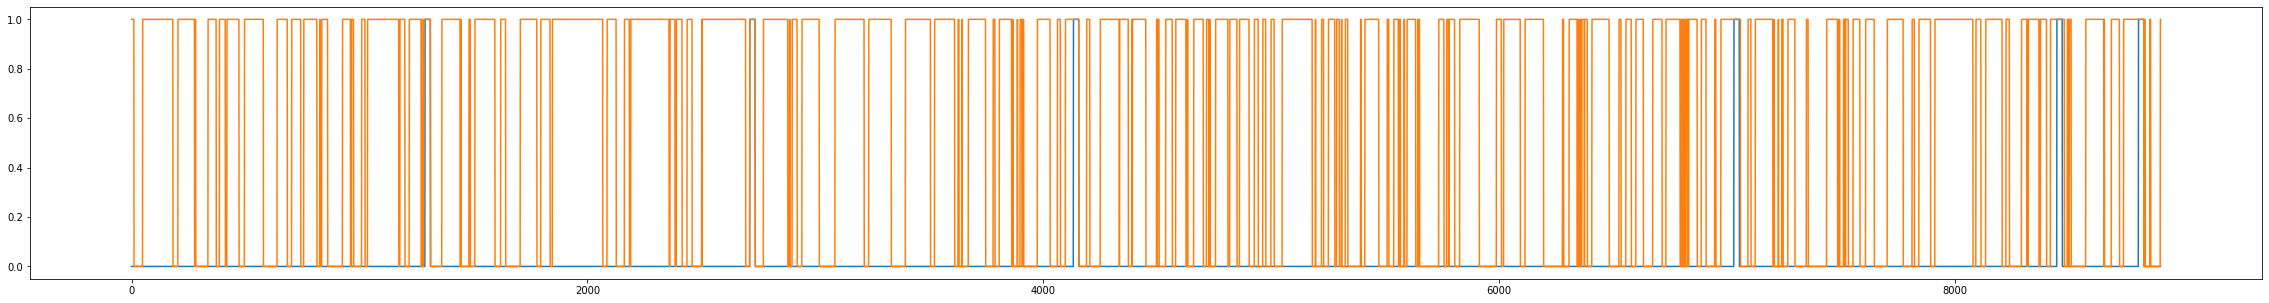

In [34]:
evaluate(true, pred, adjust=True, plot=True, print_=True)

# Multivariate

## OCSVM

In [41]:
from sklearn.svm import OneClassSVM

In [42]:
train_df.columns

Int64Index([1030001800, 1030002400, 1030002701, 1030016506, 1030040600,
            1030041300, 1030045400, 1030065700, 1050000301, 1050060000,
            1020000902, 1030000500, 1030000700, 1030001100, 1030001300,
            1030008004, 1030026600, 1030028600, 1030029200, 1030029600,
            1030001902],
           dtype='int64', name='sid')

In [43]:
pred_all = []
for sid in tqdm(train_df.columns):
    print("sid = ", sid)
    ## data
    train_data, test_data = [], []
    for i in (range(train_df.shape[0]-24)):
        if 1 in train_label.iloc[i:i+24]['label'].values:
            continue
        else:
            train_data.append(train_df.iloc[i:i+24][sid])
    for i in (range(test_df.shape[0]-24)):
        test_data.append(test_df.iloc[i:i+24][sid])
    train_data = np.stack(train_data)
    test_data = np.stack(test_data)
    
    ## train
    clf = OneClassSVM(gamma='auto').fit(train_data[:])
    # print("train done!")
    ## test
    pred = clf.predict(test_data)
    pred = [1 if p==1 else 0 for p in pred]
    pred_all.append(pred)
    # print("Prediction done!")

  0%|          | 0/21 [00:00<?, ?it/s]

sid =  1030001800


  5%|▍         | 1/21 [00:29<09:51, 29.59s/it]

sid =  1030002400


 10%|▉         | 2/21 [00:59<09:22, 29.60s/it]

sid =  1030002701


 14%|█▍        | 3/21 [01:31<09:13, 30.75s/it]

sid =  1030016506


 19%|█▉        | 4/21 [01:58<08:18, 29.33s/it]

sid =  1030040600


 24%|██▍       | 5/21 [02:26<07:43, 28.97s/it]

sid =  1030041300


 29%|██▊       | 6/21 [02:56<07:18, 29.20s/it]

sid =  1030045400


 33%|███▎      | 7/21 [03:27<06:57, 29.80s/it]

sid =  1030065700


 38%|███▊      | 8/21 [03:56<06:24, 29.56s/it]

sid =  1050000301


 43%|████▎     | 9/21 [04:25<05:50, 29.24s/it]

sid =  1050060000


 48%|████▊     | 10/21 [04:53<05:19, 29.02s/it]

sid =  1020000902


 52%|█████▏    | 11/21 [05:22<04:51, 29.13s/it]

sid =  1030000500


 57%|█████▋    | 12/21 [05:55<04:30, 30.08s/it]

sid =  1030000700


 62%|██████▏   | 13/21 [06:25<04:01, 30.21s/it]

sid =  1030001100


 67%|██████▋   | 14/21 [06:54<03:27, 29.71s/it]

sid =  1030001300


 71%|███████▏  | 15/21 [07:23<02:58, 29.67s/it]

sid =  1030008004


 76%|███████▌  | 16/21 [07:52<02:26, 29.29s/it]

sid =  1030026600


 81%|████████  | 17/21 [08:21<01:57, 29.41s/it]

sid =  1030028600


 86%|████████▌ | 18/21 [08:50<01:27, 29.23s/it]

sid =  1030029200


 90%|█████████ | 19/21 [09:18<00:57, 28.68s/it]

sid =  1030029600


 95%|█████████▌| 20/21 [09:47<00:28, 28.90s/it]

sid =  1030001902


100%|██████████| 21/21 [10:20<00:00, 29.57s/it]


In [46]:
pred = list(map(int, (np.sum(pred_all, axis=0) > 0)))

Accuracy 	0.0202
AUC score 	0.5021
FAR score 	0.9838
Precision 	0.0162
Recall   	1.0000
Macro F1 	0.0201
Avg Precision 	0.0162
              precision    recall  f1-score   support

           0       1.00      0.00      0.01      8760
           1       0.02      1.00      0.03       144

    accuracy                           0.02      8904
   macro avg       0.51      0.50      0.02      8904
weighted avg       0.98      0.02      0.01      8904



[0.02021563342318059,
 0.502054794520548,
 0.9837618403247632,
 0.016238159675236806,
 1.0,
 0.020071464513890528,
 0.016238159675236806]

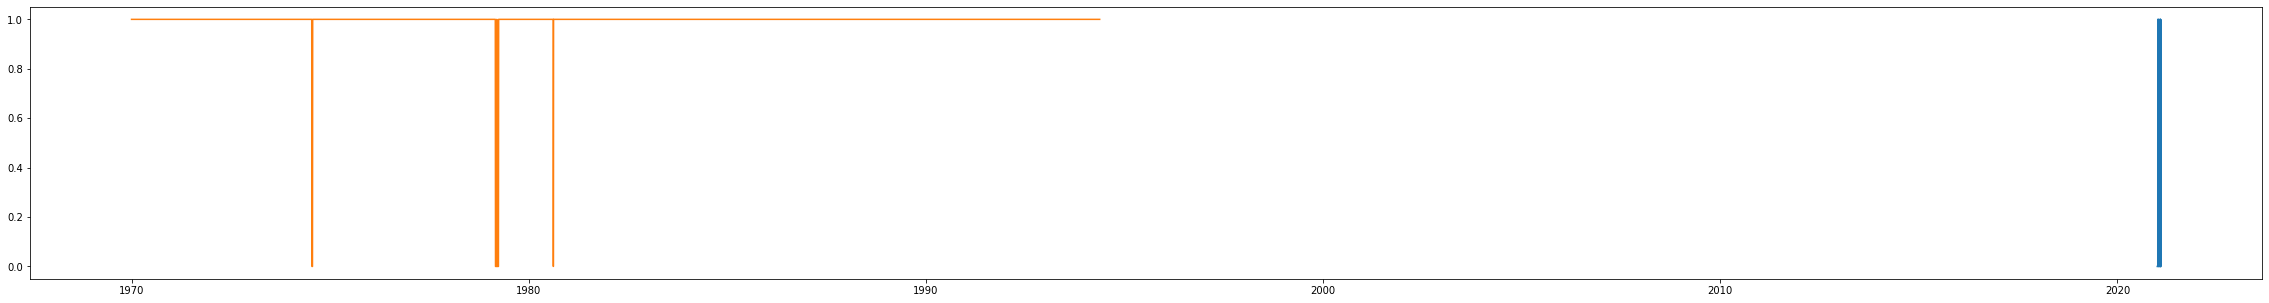

In [47]:
true = test_label.iloc[24:].label
evaluate(true, pred, adjust=True, print_=True, plot=True)